In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from tensorflow.keras import layers 
from tensorflow import keras
from tensorflow.keras.models import Sequential

print(tf.__version__)


2.12.0


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 4s 0us/step


In [4]:
image_count =  len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


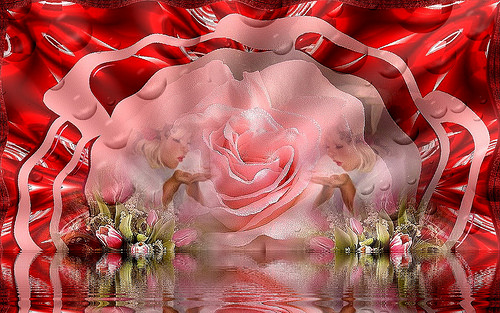

In [5]:
roses =  list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

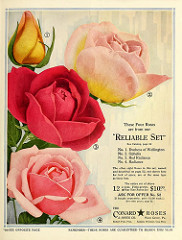

In [6]:
PIL.Image.open(str(roses[1]))


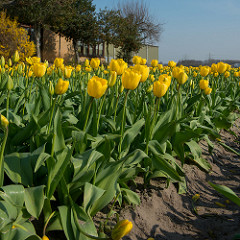

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

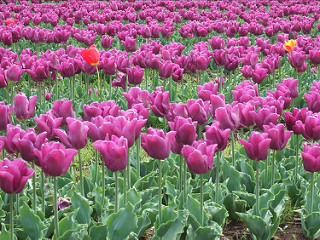

In [10]:

PIL.Image.open(str(tulips[1]))

In [17]:
#Creating Dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds =  tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset =  "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size =  batch_size
) 

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
#Adding Class Names
class_names =  train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


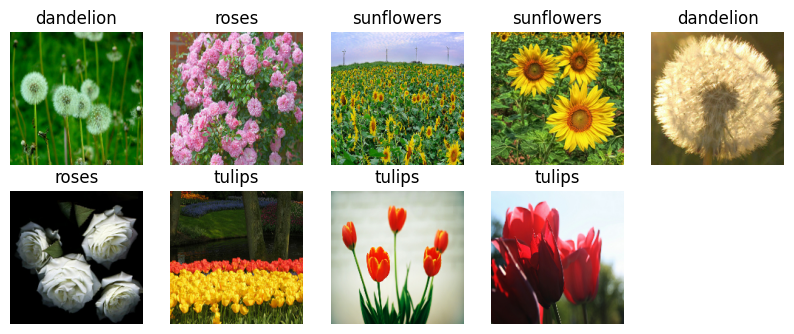

In [21]:
#Visualize data
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax =  plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [23]:
#Configure the dataset for Performance
AUTOTUNE =  tf.data.AUTOTUNE

train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
vald_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE ) 

In [24]:
#Standardize the data
normalization_layer =  layers.Rescaling(1./255)

In [27]:
normalize_ds =  train_ds.map(lambda x,y:(normalization_layer(x), y))
image_batch , labels_batch =  next(iter(normalize_ds))
first_image =  image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9836597


In [33]:
num_classes =  len(class_names)

model =  Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)


])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        1

In [41]:
#Training the Model
epochs = 10
history = model.fit(
    train_ds,
    validation_data =  val_ds,
    epochs = epochs
) 

Epoch 1/10
92/92 [==============================] - 114s 1s/step - loss: 1.3075 - accuracy: 0.4397 - val_loss: 1.1379 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 111s 1s/step - loss: 0.9656 - accuracy: 0.6257 - val_loss: 0.9373 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 111s 1s/step - loss: 0.7690 - accuracy: 0.7084 - val_loss: 0.8568 - val_accuracy: 0.6771
Epoch 4/10
92/92 [==============================] - 109s 1s/step - loss: 0.5203 - accuracy: 0.8059 - val_loss: 0.8982 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 107s 1s/step - loss: 0.2900 - accuracy: 0.8995 - val_loss: 1.0342 - val_accuracy: 0.6580
Epoch 6/10
92/92 [==============================] - 106s 1s/step - loss: 0.1729 - accuracy: 0.9435 - val_loss: 1.1903 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 111s 1s/step - loss: 0.1056 - accuracy: 0.9687 - val_loss: 1.3939 - val_accuracy: 0.6526
Epoch 8/10
92

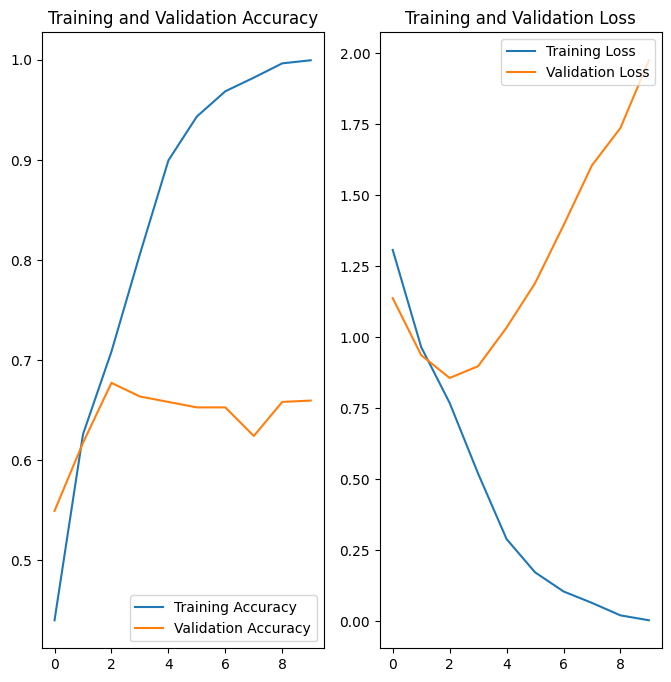

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

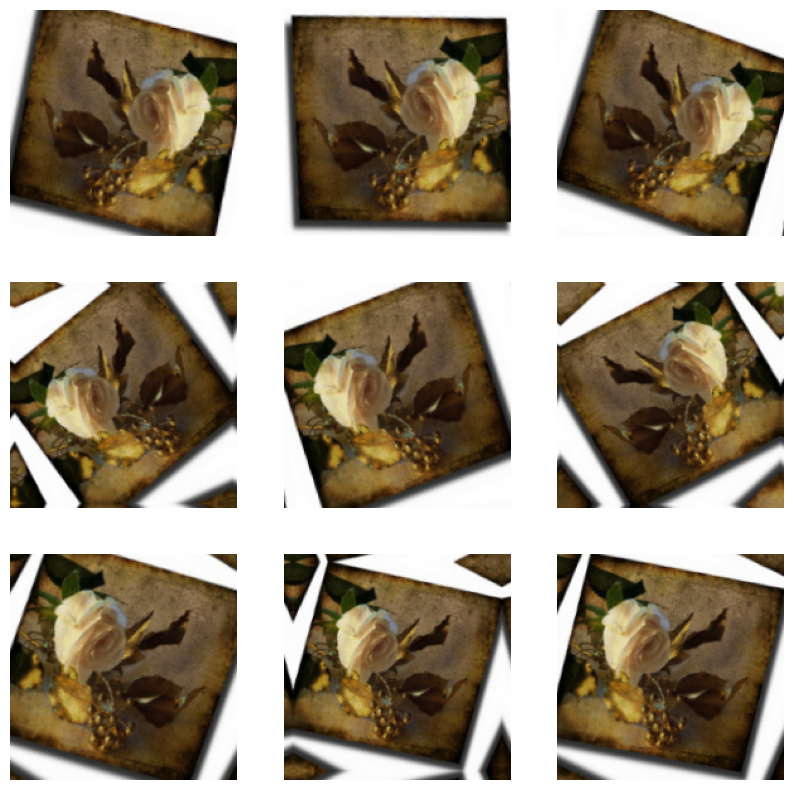

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [45]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [47]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 129s 1s/step - loss: 1.3049 - accuracy: 0.4353 - val_loss: 1.1848 - val_accuracy: 0.4837
Epoch 2/15
92/92 [==============================] - 123s 1s/step - loss: 1.0585 - accuracy: 0.5681 - val_loss: 0.9657 - val_accuracy: 0.6253
Epoch 3/15
92/92 [==============================] - 125s 1s/step - loss: 0.9688 - accuracy: 0.6192 - val_loss: 0.8759 - val_accuracy: 0.6621
Epoch 4/15
92/92 [==============================] - 123s 1s/step - loss: 0.8847 - accuracy: 0.6645 - val_loss: 0.9372 - val_accuracy: 0.6403
Epoch 5/15
92/92 [==============================] - 126s 1s/step - loss: 0.8473 - accuracy: 0.6761 - val_loss: 0.8512 - val_accuracy: 0.6689
Epoch 6/15
92/92 [==============================] - 124s 1s/step - loss: 0.8109 - accuracy: 0.6901 - val_loss: 0.8338 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 123s 1s/step - loss: 0.7686 - accuracy: 0.6921 - val_loss: 0.7753 - val_accuracy: 0.7016
Epoch 8/15
92

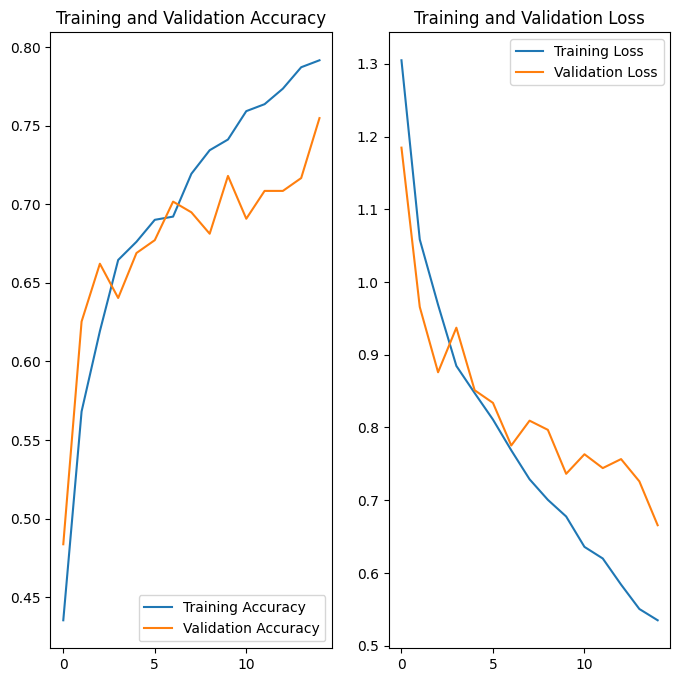

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 397ms/step
This image most likely belongs to sunflowers with a 99.29 percent confidence.
